# Lab 1: Document Processing with OCR

In this lesson, you will build an agent for document processing with optical character recognition (OCR). 

**Learning Objectives:**
- Parsing and extracting information from documents 
- Building an agent equipped with an OCR tool
- Identifying failure modes of OCR

## Background

Document processing converts unstructured documents meant for humans into structured data meant for machines. When documents are scanned images, OCR converts pixels to text. However, OCR alone produces raw text. Using LLMs, we can make sense of it.  

## Outline

- [1. Import Libraries](#1)
- [2. Create OCR Tool](#2)
  - [2.1. Use OCR to Parse a Sample Document](#2-1)
  - [2.2. Use Regex to Extract Information](#2-2)
- [3. Create the Agent](#3)
- [4. Run the Agent and Extract Information](#4)
- [5. OCR Limitations](#5)

<a id="1"></a>

## 1. Import Libraries

Import the packages needed for the document processing system:

- **Pillow (PIL)**: Load and manipulate images
- **Pytesseract**: Python wrapper for Tesseract OCR engine
- **LangChain**: Framework for building tool-enabled LLM applications
- **OpenAI models**: LLM that provides reasoning capabilities

In [ ]:
# import langchain
# print(langchain.__version__)

In [1]:
from PIL import Image
from pathlib import Path
import pytesseract

# from langchain.agents import create_react_agent
# from langgraph.prebuilt import create_react_agent
# from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain.agents import AgentExecutor

# from langchain_openai import ChatOpenAI

<a id="2"></a>

## 2. Create OCR Tool

The @tool decorator from LangChain transforms a function into a tool for use by agents.

In [2]:
from langchain.tools import tool

@tool
def ocr_read_document(image_path: str) -> str:
    """Reads an image from the given path and returns extracted text using OCR."""
    try:
        text = pytesseract.image_to_string(Image.open(image_path))
        return text
    except Exception as e:
        return f"Error reading image: {e}"

<a id="2-1"></a>

### 2.1. Use OCR to Parse a Sample Document

Here's a clean digital invoice with crisp fonts, no handwriting, and no shadows. 

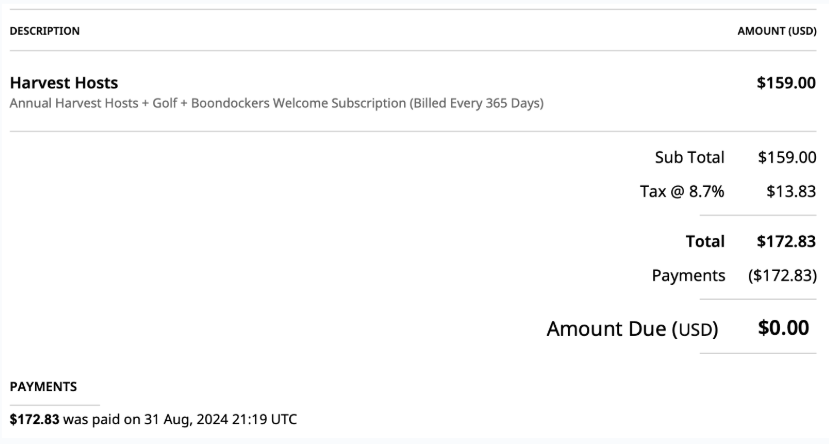

In [3]:
from IPython.display import display

# Define the data directory and image path
image_dir = Path("../../data/imgs")
docs_dir = Path("../../data/docs")
image_path = image_dir / "invoice.png"
img = Image.open(str(image_path))
display(img)

Now run the OCR tool on the invoice. 

In [4]:
ocr_text = ocr_read_document.run(str(image_path))
print("Raw OCR Output:\n----------------\n", ocr_text)

Raw OCR Output:
----------------
 DESCRIPTION AMOUNT (USD)

Harvest Hosts $159.00
Annual Harvest Hosts + Golf + Boondockers Welcome Subscription (Billed Every 365 Days)

Sub Total $159.00
Tax @ 8.7% $13.83

Total $172.83
Payments ($172.83)

Amount Due (USD) $0.00

PAYMENTS

$172.83 was paid on 31 Aug, 2024 21:19 UTC



<a id="2-2"></a>

### 2.2. Use Regex to Extract Information

Let's use regular expressions (regex) to extract tax and total from the parsed invoice. The patterns will look for "Tax" and "Total" to capture the respective numbers allowing for optional spacing and dollar sign.

In [ ]:
# import re

# # Regex to find Tax or Total
# tax_match = re.search(r'Tax\s*\$?([0-9.,]+)', ocr_text)
# total_match = re.search(r'Total\s*\$?([0-9.,]+)', ocr_text)

# # Print tax amount if found
# if tax_match:
#     print("Tax found by regex:", tax_match.group(1))
# else:
#     print("Tax not found by regex.")

# # Print total amount if found
# if total_match:
#     print("Total found by regex:", total_match.group(1))
# else:
#     print("Total not found by regex.")

The regex pattern for "Tax" failed because the OCR output had "Tax @", not just "Tax."

The regex pattern matched "Sub Total" instead of "Total" because it appeared first and fit the pattern.

<a id="3"></a>

## 3. Create the Agent

Let's build an agent to parse and extract information from the invoice. For parsing, you will use OCR as a tool. For extracting, you will use LLMs as opposed to regex.


In [ ]:
# import os
# from dotenv import load_dotenv

# # Load environment variables from .env
# _ = load_dotenv(override=True)

Here we load the API key for OpenAI from a configuration file. 

In [5]:
# 1. Define the list of tools
tools = [ocr_read_document]

# 2. Set up the OpenAI model
# from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(
#     model="gpt-5-mini", 
#     temperature=1
# )

from langchain_ollama import OllamaLLM
llm = OllamaLLM(model="llama3.2:1b")
print(llm.invoke("What is the capital of France?"))

The capital of France is Paris.


Now create the agent using the ReAct framework with the LLM, tools, and prompt. Then set up the `AgentExecutor` to run the agent loop. 

In [9]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain.agents import create_tool_calling_agent
# from langchain.agents import AgentExecutor

from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt import chat_agent_executor

# 3. Create the OpenAI-compatible prompt
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant designed to extract information from documents." 
            "You have access to this tool: "
            "OCR tool to extract raw text from images "
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

# 4. Create a proper tool-calling agent
agent = create_react_agent(llm, tools, prompt)

# 5. Set up the AgentExecutor to run the tool-enabled loop
agent_executor = chat_agent_executor(agent=agent, tools=tools, verbose=True)

/tmp/ipykernel_261897/567239634.py:23: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(llm, tools, prompt)


TypeError: create_react_agent() takes 2 positional arguments but 3 were given

<a id="4"></a>

## 4. Run the Agent and Extract Information

Having implemented the agent, we can pass it a prompt for parsing and extracting information from the invoice.


During the agent loop, the LLM decides when to call the OCR tool, receives the text output, and continues reasoning.

In [ ]:
task = """
Please process the document at 'invoice.png' using the OCR tool 
and extract the following information in JSON format:
- tax
- total
"""

# Use .invoke() with a dictionary input for the agent_executor
response = agent_executor.invoke({"input": task})

The agent returns JSON with the correct tax and total (not the subtotal). The LLM's comprehension capabilities enable the agent to extract information correctly based on the OCR output.

<a id="5"></a>

## 5. OCR Limitations

The combination of OCR for parsing and regex for extracting worked on the previous example. However real-world documents can have complex layout or low resolution. Let's explore three examples. 

### 5.1. Complex Tables

Tables are difficult for OCR. Misalignment of entries with unclear delineation between rows and columns can lead to poor results.  

In [ ]:
image_path = 'table.png'
img = Image.open(image_path)
display(img)

Extract the training cost in FLOPs from the EN-DE column.

In [ ]:
task = """
Extract the Training Cost (FLOPs) for EN-DE for ALL methods from the table.png 
using the OCR tool.
Return as a list with model name and its training cost.
"""

# First, get the raw OCR output
ocr_output = ocr_read_document.run("table.png")

# Use .invoke() with a dictionary input for the agent_executor
response = agent_executor.invoke({"input": task})

# Display results side by side
print("="*80)
print(" " * 22 + "OCR TABLE RESULTS")
print("="*80)
print("\n" + "─"*35 + " OCR OUTPUT " + "─"*33)
print(ocr_output[:600] + "..." if len(ocr_output) > 600 else ocr_output)
print("\n" + "─"*35 + " LLM RESULT " + "─"*33)
print(response["output"])
print("="*80)

There are several issues with the results: 

- Exponents become apostrophes
- Decimals become exclamation points
- Columns are misaligned

While the LLM can recognize patterns like empty cells, it may extract incorrect values from wrong columns due to garbled OCR output.

### 5.2. Handwriting

OCR struggles with handwriting. This is a fill-in-the-blanks exercise.

In [ ]:
image_path = 'fill_in_the_blanks.jpg'
img = Image.open(image_path)
display(img)

Extract the student name and all answers from the handwritten worksheet.

In [ ]:
task = """
Please process the document at 'fill_in_the_blanks.jpg' using ocr 
and extract the following information in JSON format:
- `student name`
- `student answer to all the ten questions`
"""

# First, get the raw OCR output
ocr_output = ocr_read_document.run("fill_in_the_blanks.jpg")

# Use .invoke() with a dictionary input for the agent_executor
response = agent_executor.invoke({"input": task})

# Display results side by side
print("="*80)
print(" " * 22 + "HANDWRITTEN WORKSHEET RESULTS")
print("="*80)
print("\n" + "─"*35 + " OCR OUTPUT " + "─"*33)
print(ocr_output[:600] + "..." if len(ocr_output) > 600 else ocr_output)
print("\n" + "─"*35 + " LLM RESULT " + "─"*33)
print(response["output"])
print("="*80)

### 5.3. Low-Quality Receipts
Receipts are messy owing to low resolution, thermal printing, misaligned text, and shadows. 

In [ ]:
image_path = 'receipt.jpg'
img = Image.open(image_path)
display(img)

Ask the agent to verify if the total on the receipt is mathematically correct.

In [ ]:
task = """
Please process the document at 'receipt.jpg' and evaluate the correctness 
of the total.
"""

# Use .invoke() with a dictionary input for the agent_executor
response = agent_executor.invoke({"input": task})

Look at the first line item. The actual value is \\$7.95. But OCR misreads it as \\$7.99. This small numerical error throws off the entire total calculation. The answer is incorrect because the OCR tool didn't capture the numbers accurately. 

## Summary

Here's what we covered:

|  | Applications | Limitations |
|-----------|----------|------------|
| **OCR** | Good at parsing simple text | Bad at tables, handwriting, low-quality scans |
| **Regex** | Good at pattern matching | Bad at handling variations in text |
| **Agent** | Can adapt to variations in text | Dependent on OCR quality; otherwise may hallucinate |

In the next lesson, we will explore how OCR has evolved over four decades and why that evolution matters for document processing.